## Elaborato Esame - Problema di Classificazione
**Programmazione di applicazioni data intensive a.a. 2022/23**  
Laurea in ingegneria e scienze informatiche  
DISI - Università di Bologna, Campus di Cesena  

 Candidato: **Nicola Costa**  
 E-mail: nicola.costa5@studio.unibo.it  
 Matricola: 0000922493  

Questo elaborato presenta un problema di classificazione. <br>
Il dataset che utilizzeremo deriva dal [Blood Transfusion Service Center](https://www.openml.org/search?type=data&sort=runs&id=1464&status=active) della città di Hsin-Chu in Taiwan e contiene informazioni relative ai suoi donatori di sangue, come ad esempio i mesi passati dall'ultima donazione, il numero totale di donazioni, ecc. <br>
**Vogliamo predire, utilizzando diversi modelli di classificazione, se la persona donatrice ha donato il sangue nel marzo 2007.**

### Librerie utilizzate

In [1]:
import pandas as pd
from scipy.io.arff import loadarff
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE  # pip install imblearn

### Caricamento dei dati

Il dataset scaricato è racchiuso in un file *.arff*, un formato di file adatto a contenere i dati e costrutti di un database relazionale. Attraverso le keyword *@relation*, *@attribute* e *@data* si specificano rispettivamente relazioni, attributi e tuple.  
Nel nostro caso sono presenti solo attributi, che diventeranno le nostre features/colonne, e tuple, che diventeranno le istanze.

Con il metodo `loadarff` leggiamo il dataset e lo carichiamo in un DataFrame pandas (nell'indice 0 di `arff_data` ci sono le tuple, nell'indice 1 invece i tipi degli attributi).

In [2]:
arff_data = loadarff("php0iVrYT.arff")
btscds = pd.DataFrame(arff_data[0])

In [3]:
btscds.head(10)

,V1,V2,V3,V4,Class
0,2.0,50.0,12500.0,98.0,b'2'
1,0.0,13.0,3250.0,28.0,b'2'
2,1.0,16.0,4000.0,35.0,b'2'
3,2.0,20.0,5000.0,45.0,b'2'
4,1.0,24.0,6000.0,77.0,b'1'
5,4.0,4.0,1000.0,4.0,b'1'
6,2.0,7.0,1750.0,14.0,b'2'
7,1.0,12.0,3000.0,35.0,b'1'
8,2.0,9.0,2250.0,22.0,b'2'
9,5.0,46.0,11500.0,98.0,b'2'


### Comprensione dei dati

In [4]:
btscds.shape

(748, 5)

Con l'attributo `shape` visualizziamo le cardinalità del dataframe: abbiamo 748 istanze e 5 features.

In [5]:
btscds.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      748 non-null    float64
 1   V2      748 non-null    float64
 2   V3      748 non-null    float64
 3   V4      748 non-null    float64
 4   Class   748 non-null    object 
dtypes: float64(4), object(1)
memory usage: 54.2 KB


Le feature sono riferite ad una persona donatrice di sangue e hanno i seguenti significati:
- `V1`: vicinanza - mesi passati dall'ultima donazione.
- `V2`: frequenza - numero totale di donazioni.
- `V3`: valore monetario - totale sangue donato in centimetri cubi.
- `V4`: tempo - mesi passati dalla prima donazione.
- `Class`: donazione - vale '2' se la persona ha donato il proprio sangue a marzo 2007, '1' altrimenti.

**La colonna** `Class` **è la variabile target discreta binaria indicante la classe di appartenenza del donatore.**

In [6]:
btscds["Class"] = pd.to_numeric(btscds["Class"])  # Object ==> int64

In [7]:
btscds.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      748 non-null    float64
 1   V2      748 non-null    float64
 2   V3      748 non-null    float64
 3   V4      748 non-null    float64
 4   Class   748 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 29.3 KB


Rendendo `Class` numerica abbiamo vantaggi in termini di memoria occupata, utilizzandone circa la metà di prima.

### Analisi esplorativa

Dalla stampa di `info` qui sopra possiamo vedere come non ci siano valori nulli: tutte le colonne hanno 748 valori *non-null* su 748 istanze. Infatti:

In [8]:
btscds.isna().sum()

V1       0
V2       0
V3       0
V4       0
Class    0
dtype: int64

Con `describe` visualizziamo le statistiche di base di ogni features, tra cui media, deviazione standard e quartili.  
Queste informazioni sono utili anche per considerare la standardizzazione dei dati:

In [9]:
btscds.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,748.0,9.506684,8.095396,0.0,2.75,7.0,14.0,74.0
V2,748.0,5.514706,5.839307,1.0,2.00,4.0,7.0,50.0
V3,748.0,1378.676471,1459.826781,250.0,500.00,1000.0,1750.0,12500.0
V4,748.0,34.282086,24.376714,2.0,16.00,28.0,50.0,98.0
Class,748.0,1.237968,0.426124,1.0,1.00,1.0,1.0,2.0


Come possiamo notare, tutte le features, tranne `V3` che ricordiamo indica il totale di sangue donato in cc, hanno deviazioni standard e medie abbastanza vicine. Applicheremo la standardizzazione durante le fasi successive e confronteremo i risultati dei modelli con e senza di essa.

Visualizziamo la distribuzione di `Class`:

In [10]:
btscds["Class"].value_counts()

1    570
2    178
Name: Class, dtype: int64

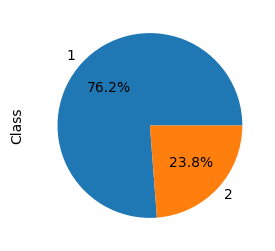

In [11]:
btscds["Class"].value_counts().plot.pie(figsize=(3,3), autopct="%.1f%%");

Come possiamo vedere, il 76.2 % di persone NON hanno donato il sangue a marzo 2007, mentre il restante 23.8 % lo ha fatto.

#### Correlazione tra variabili

Visualizziamo ora quanto le variabili predittive `V1`, `V2`, `V3` e `V4` siano correlate con la classe da predire `Class` attraverso degli istogrammi *stacked*. In questo modo otterremo le loro distribuzioni in rapporto con la classe, differenziando i casi di donatori (2 - arancione) e non donatori (1 - blu).

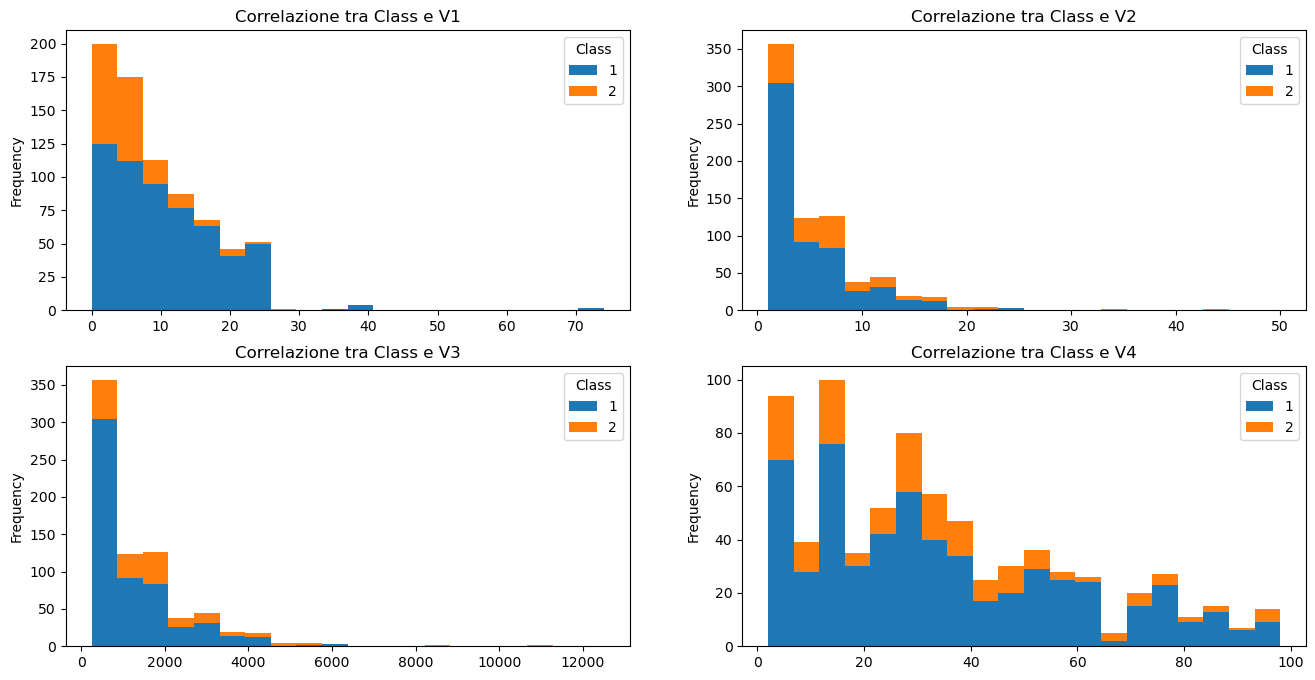

In [12]:
plt.figure(figsize=(16, 8))
for n, col in enumerate(["V1", "V2", "V3", "V4"], start=1):
    btscds.pivot(columns="Class")[col].plot.hist(bins=20, stacked=True, ax=plt.subplot(2, 2, n)) \
    .set_title(f"Correlazione tra Class e {col}")

In ogni grafico si riconferma lo sbilanciamento dei donatori e non donatori. Inoltre, sono praticamente sempre accavallati.

Attraverso il *coefficiente di Pearson* (metodo `corr` del DataFrame) quantifichiamo il grado di correlazione tra una variabile e l'altra:

In [13]:
btscds.corr().style.background_gradient(cmap="bwr")

,V1,V2,V3,V4,Class
V1,1.000000,-0.182745,-0.182745,0.160618,-0.279869
V2,-0.182745,1.000000,1.000000,0.634940,0.218633
V3,-0.182745,1.000000,1.000000,0.634940,0.218633
V4,0.160618,0.634940,0.634940,1.000000,-0.035854
Class,-0.279869,0.218633,0.218633,-0.035854,1.000000


Escludiamo la correlazione tra le stesse variabili che è sempre uguale a 1. C'è una correlazione diretta al 100 % tra `V2` e `V3`: significa che il numero totale di sangue donato è direttamente proporzionale al numero totale di donazioni e viceversa.

Con un veloce calcolo, prendendo i valori dalla prima stampa `head` nel **caricamento dei dati**, `V3` = 250 · `V2`. <br>
Ciò è probabilmente dovuto al fatto che, ad ogni sessione di donazione, viene prelevata sempre la stessa quantità di sangue.

Vi è una discreta correlazione tra `V2` e `V4` e tra `V3` e `V4`. <br>
Le altre coppie hanno invece correlazione pressochè nulla perchè sono molto vicine allo 0.

Infine, visualizziamo anche i diagrammi a dispersione con la distribuzione delle variabili due a due, differenziando i punti per colore: donatori = arancione e non donatori = blu.

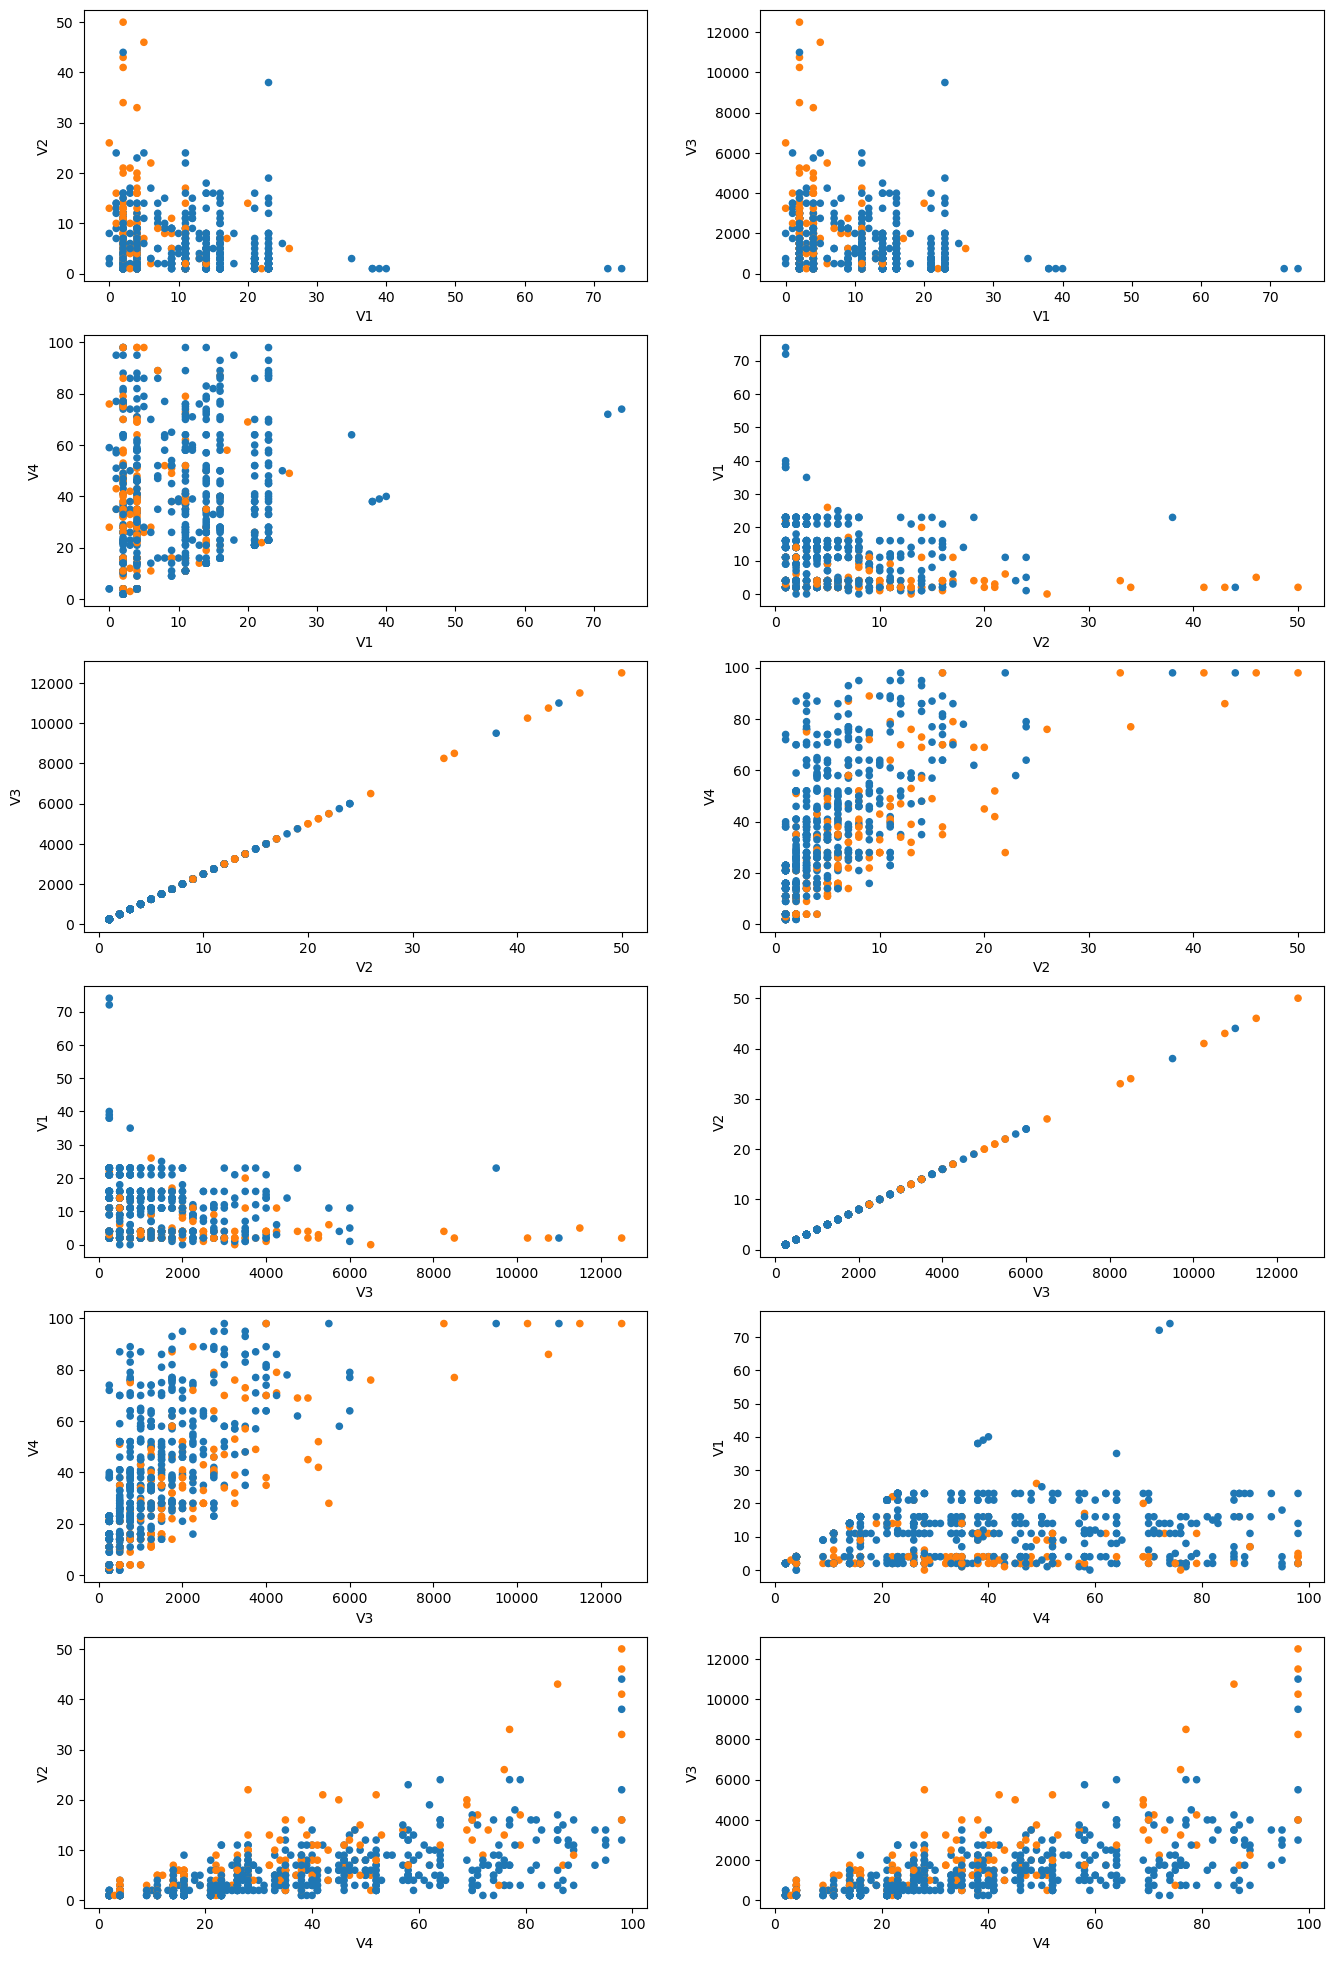

In [14]:
color_map = {1: "#1f77b4", 2: "#ff7f0e"}  # non donatori (1) ==> blu, donatori (2) ==> arancione
colors = btscds["Class"].map(color_map)
i = 1

plt.figure(figsize=(16, 50))
for col1 in ["V1", "V2", "V3", "V4"]:
    for col2 in ["V1", "V2", "V3", "V4"]:
        if col1 != col2:
            btscds.plot.scatter(col1, col2, c=colors, ax=plt.subplot(12, 2, i));
            i += 1

Con questi rivediamo la correlazione diretta in `V2` e `V3` rappresentata da una "retta". <br>
Sfortunatamente però notiamo anche la pessima distribuzione dei punti colorati in tutti i grafici, ossia tutti mischiati (precedentemente l'abbiamo vista anche con l'accavallamento negli istogrammi). <br>
**Ciò ci porta a pensare che le accuratezze dei modelli di classificazione saranno po' basse**.

### Operazioni preliminari alla classificazione

Estraiamo dal Dataframe il vettore y con la variabile dipendente `Class` e la matrice X con le variabili indipendenti (tutte le altre colonne).

In [15]:
y = btscds["Class"]
X = btscds.drop(columns=["Class"])

#### Definizione dei modelli, delle metriche e altri metodi

Per eseguire test affidabili sui modelli, utilizzeremo prima il metodo *hold-out* per suddividere i dati in *training set* e *validation set*, poi lo *stratified k cross fold validation* per garantire la stessa proporzione tra le classi in tutti i *fold*.

In [16]:
def do_holdout(X, y):
    """
    Suddivide i dati in input in train e validation set. Restituisce X_train, X_val, y_train e y_val.
    """
    return train_test_split(
        X, y,
        test_size=1/3,  # 1/3 dei dati è nel validation set, 2/3 nel training set
        random_state=42
    )

In [17]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)

Applicheremo, come accennato prima, la **standardizzazione** ai dati (avranno così la stessa deviazione standard). Ecco il metodo che utilizzeremo:

In [18]:
def do_standardization(X_train, X_val):
    """
    Crea lo Standard Scaler e lo applica ai dati in input. Restituisce quindi i dati standardizzati.
    """
    scaler = StandardScaler()
    new_X_train = scaler.fit_transform(X_train)
    new_X_val = scaler.transform(X_val)
    return new_X_train, new_X_val

Di seguito i metodi per utilizzare i 3 algoritmi di classificazione: ***Perceptron***, ***Regressione Logistica*** e ***alberi decisionali***.

In [19]:
def do_perceptron(X_train, y_train, weight=None):
    """
    Crea il modello Perceptron e lo addestra con i dati in input. Restituisce quindi il modello addestrato.
    """
    model = Perceptron(random_state=42, class_weight=weight)
    model.fit(X_train, y_train)
    return model

In [20]:
def do_logistic_regression(X_train, y_train, grid, weight=None):
    """
    Crea il modello di Regressione Logistica ed esegue una Grid Search per individuare i parametri migliori.
    Restituisce il miglior modello addestrato sui dati in input.
    """
    model = LogisticRegression(solver="saga", random_state=42, class_weight=weight)
    gs = GridSearchCV(model, grid, cv=skf)
    gs.fit(X_train, y_train)
    return gs.best_estimator_

In [21]:
def do_decision_tree_classifier(X_train, y_train, grid, weight=None):
    """
    Crea l'albero di classificazione ed esegue una Grid Search per individuare i parametri migliori.
    Restituisce il miglior modello addestrato sui dati in input.
    """
    model = DecisionTreeClassifier(max_depth=2, class_weight=weight)
    gs = GridSearchCV(model, grid, cv=skf)
    gs.fit(X_train, y_train)
    return gs.best_estimator_

Per visualizzare come le istanze sono state suddivise dal modello utilizziamo la *matrice di confusione*. <br>
Mentre per calcolare l'**accuratezza** dei modelli utilizziamo il *precision score*, il *recall score* e la *F1-measure*.

In [22]:
def do_confusion_matrix(model, X_val, y_val):
    """
    Calcola la matrice di confusione sul modello e i dati in input. Restituisce la matrice sottoforma di DataFrame.
    """
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    return pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

In [23]:
def get_model_accurancy(model, X_val, y_val):
    """
    Calcola l'accuratezza del modello sui dati in input con precision, recall e f1-measure, poi stampa i risultati.
    Restituisce f1-measure.
    """
    y_pred = model.predict(X_val)
    precision = precision_score(y_val, y_pred, pos_label=2)
    recall = recall_score(y_val, y_pred, pos_label=2)
    f1 = f1_score(y_val, y_pred, average="macro")
    
    print(f"Accuratezza del modello '{model}': \nPrecision: {precision} \nRecall: {recall} \nF1-measure: {f1}")
    return f1

#### Collinearità

Siccome abbiamo un caso di collinearità, possiamo scartare una delle variabili affette: `V2` o `V3`. Utilizziamo la ***Regressione Logistica con regolarizzazione L1*** per individuare le feature più rilevanti ed in questo modo vedere quale delle due scartare.

In [24]:
model = LogisticRegression(solver="saga", random_state=42, penalty="l1", C=0.01)

In [25]:
X_col_train, X_col_val, y_col_train, y_col_val = do_holdout(X, y)  # applichiamo hold-out ai dati

In [26]:
model.fit(X_col_train, y_col_train)

C:\Users\nicol\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.01, penalty='l1', random_state=42, solver='saga')

In [27]:
model.coef_[0] # stampa i coefficienti di V1, V2, V3, V4

array([-0.00173434,  0.        , -0.00019201, -0.00314174])

Vediamo azzerato il coefficiente della variabile `V2` meno significativa: elimineremo quella.

In [28]:
X = X.drop(columns=["V2"])

In [29]:
X.head(5)

,V1,V3,V4
0,2.0,12500.0,98.0
1,0.0,3250.0,28.0
2,1.0,4000.0,35.0
3,2.0,5000.0,45.0
4,1.0,6000.0,77.0


---
Un quarto di donatori e tre quarti di non donatori sono quantità sbilanciate, quindi dobbiamo considerare delle tecniche di bilanciamento delle classi, confrontare le performance dei modelli su quelle e scegliere il migliore.  
Le tecniche che considereremo sono *oversampling*, *undersampling* e l'aumento del peso degli errori della classe con meno istanze (donatori).

In [30]:
# dizionario che ospiterà le accuratezze dei modelli
# chiave ==> tecnica bilanciamento, valore ==> dizionario con chiave ==> modello, valore ==> accuratezza
models_accurancies = {"oversampling": dict(), "undersampling": dict(), "weight": dict()}

### Classificazione con *oversampling*

Effettuiamo il bilanciamento dei dati con la tecnica di *oversampling* **SMOTE**.

In [31]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

In [32]:
X_smote.shape

(1140, 3)

In questo modo abbiamo 1140 istanze totali nella matrice delle variabili indipendenti.

In [33]:
y_smote.value_counts()

2    570
1    570
Name: Class, dtype: int64

Ed abbiamo bilanciato la classe in 570 donatori e 570 non donatori.

In [34]:
X_sm_train, X_sm_val, y_sm_train, y_sm_val = do_holdout(X_smote, y_smote)  # applichiamo hold-out ai dati

In [35]:
X_sm_train, X_sm_val = do_standardization(X_sm_train, X_sm_val)  # standardizziamo le variabili indipendenti

#### Perceptron

In [36]:
model = do_perceptron(X_sm_train, y_sm_train)
model

Perceptron(random_state=42)

In [37]:
model.score(X_sm_val, y_sm_val)

0.6157894736842106

In [38]:
do_confusion_matrix(model, X_sm_val, y_sm_val)

,1,2
1,169,32
2,114,65


In [39]:
f1_measure = get_model_accurancy(model, X_sm_val, y_sm_val)

Accuratezza del modello 'Perceptron(random_state=42)': 
Precision: 0.6701030927835051 
Recall: 0.36312849162011174 
F1-measure: 0.5846808000958198


In [40]:
models_accurancies["oversampling"].update({model: f1_measure})  # salviamo il risultato nel dizionario

#### Regressione Logistica

Costruiamo una griglia con tutte le possibili combinazioni di iperparametri della regressione logistica.

In [41]:
linear_regression_grid = [
    {
        "penalty": ["l2", "l1"],
        "C": [0.01, 0.1, 1, 10, 100]
    },
    {
        "penalty": ["elasticnet"],
        "C": [0.01, 0.1, 1, 10, 100],
        "l1_ratio": [0.2, 0.5]
    },
    {
        "penalty": ["none"]  # ne l1 ne l2
    }
]

In [42]:
model = do_logistic_regression(X_sm_train, y_sm_train, linear_regression_grid)
model

LogisticRegression(C=10, random_state=42, solver='saga')

In [43]:
model.score(X_sm_val, y_sm_val)

0.718421052631579

In [44]:
do_confusion_matrix(model, X_sm_val, y_sm_val)

,1,2
1,139,62
2,45,134


In [45]:
f1_measure = get_model_accurancy(model, X_sm_val, y_sm_val)

Accuratezza del modello 'LogisticRegression(C=10, random_state=42, solver='saga')': 
Precision: 0.6836734693877551 
Recall: 0.7486033519553073 
F1-measure: 0.7183722943722943


In [46]:
models_accurancies["oversampling"].update({model: f1_measure})  # salviamo il risultato nel dizionario

#### Alberi decisionali

Qui creiamo una griglia con le possibili profondità dell'albero.

In [47]:
tree_grid = {
    "max_depth" : range(2, 13)  # da 2 a 12
}

In [48]:
model = do_decision_tree_classifier(X_sm_train, y_sm_train, tree_grid)
model

DecisionTreeClassifier(max_depth=6)

In [49]:
model.score(X_sm_val, y_sm_val)

0.7368421052631579

In [50]:
do_confusion_matrix(model, X_sm_val, y_sm_val)

,1,2
1,156,45
2,55,124


In [51]:
f1_measure = get_model_accurancy(model, X_sm_val, y_sm_val)

Accuratezza del modello 'DecisionTreeClassifier(max_depth=6)': 
Precision: 0.7337278106508875 
Recall: 0.6927374301675978 
F1-measure: 0.7349626157794888


In [52]:
models_accurancies["oversampling"].update({model: f1_measure})  # salviamo il risultato nel dizionario

### Classificazione con *undersampling*

Effettuiamo il bilanciamento diminuendo le istanze della classe più numerosa (i non donatori) fino a raggiungere il numero della meno numerosa (i donatori).

In [53]:
btscds_donors = btscds.loc[btscds["Class"] == 2, :]  # preleviamo tutti i donatori nel Dataframe y
n_donors = len(btscds_donors)
n_donors

178

In [54]:
some_btscds_non_donors = btscds.loc[btscds["Class"] == 1, :][:n_donors]  # preleviamo dal DataFrame originale i primi 178 non donatori
some_btscds_non_donors

,V1,V2,V3,V4,Class
4,1.0,24.0,6000.0,77.0,1
5,4.0,4.0,1000.0,4.0,1
7,1.0,12.0,3000.0,35.0,1
10,4.0,23.0,5750.0,58.0,1
11,0.0,3.0,750.0,4.0,1
...,...,...,...,...,...
267,11.0,8.0,2000.0,46.0,1
268,4.0,7.0,1750.0,82.0,1
269,13.0,4.0,1000.0,21.0,1
270,16.0,11.0,2750.0,40.0,1


In [55]:
btscds_undersampled = pd.concat([btscds_donors, some_btscds_non_donors], axis=0)  # concateniamo i due DataFrame
btscds_undersampled

,V1,V2,V3,V4,Class
0,2.0,50.0,12500.0,98.0,2
1,0.0,13.0,3250.0,28.0,2
2,1.0,16.0,4000.0,35.0,2
3,2.0,20.0,5000.0,45.0,2
6,2.0,7.0,1750.0,14.0,2
...,...,...,...,...,...
267,11.0,8.0,2000.0,46.0,1
268,4.0,7.0,1750.0,82.0,1
269,13.0,4.0,1000.0,21.0,1
270,16.0,11.0,2750.0,40.0,1


In [56]:
btscds_undersampled["Class"].value_counts()

2    178
1    178
Name: Class, dtype: int64

Abbiamo così bilanciato la classe in 178 donatori e 178 non donatori.

In [57]:
y_un = btscds_undersampled["Class"]
X_un = btscds_undersampled.drop(columns=["Class", "V2"])  # rimuoviamo anche la var. V2

In [58]:
X_un_train, X_un_val, y_un_train, y_un_val = do_holdout(X_un, y_un)  # applichiamo hold-out ai dati

In [59]:
X_un_train, X_un_val = do_standardization(X_un_train, X_un_val)  # standardizziamo le variabili indipendenti

#### Perceptron

In [60]:
model = do_perceptron(X_un_train, y_un_train)
model

Perceptron(random_state=42)

In [61]:
model.score(X_un_val, y_un_val)

0.46218487394957986

In [62]:
do_confusion_matrix(model, X_un_val, y_un_val)

,1,2
1,37,20
2,44,18


In [63]:
f1_measure = get_model_accurancy(model, X_un_val, y_un_val)

Accuratezza del modello 'Perceptron(random_state=42)': 
Precision: 0.47368421052631576 
Recall: 0.2903225806451613 
F1-measure: 0.44811594202898547


In [64]:
models_accurancies["undersampling"].update({model: f1_measure})  # salviamo il risultato nel dizionario

#### Regressione Logistica

Utilizziamo la stessa griglia `linear_regression_grid` di prima.

In [65]:
model = do_logistic_regression(X_un_train, y_un_train, linear_regression_grid)
model

LogisticRegression(C=0.1, l1_ratio=0.2, penalty='elasticnet', random_state=42,
                   solver='saga')

In [66]:
model.score(X_un_val, y_un_val)

0.5126050420168067

In [67]:
do_confusion_matrix(model, X_un_val, y_un_val)

,1,2
1,39,18
2,40,22


In [68]:
f1_measure = get_model_accurancy(model, X_un_val, y_un_val)

Accuratezza del modello 'LogisticRegression(C=0.1, l1_ratio=0.2, penalty='elasticnet', random_state=42,
                   solver='saga')': 
Precision: 0.55 
Recall: 0.3548387096774194 
F1-measure: 0.5024509803921569


In [69]:
models_accurancies["undersampling"].update({model: f1_measure})  # salviamo il risultato nel dizionario

#### Alberi decisionali

Utilizziamo la stessa griglia `tree_grid` di prima...

In [70]:
model = do_decision_tree_classifier(X_un_train, y_un_train, tree_grid)
model

DecisionTreeClassifier(max_depth=10)

In [71]:
model.score(X_un_val, y_un_val)

0.6050420168067226

In [72]:
do_confusion_matrix(model, X_un_val, y_un_val)

,1,2
1,46,11
2,36,26


In [73]:
f1_measure = get_model_accurancy(model, X_un_val, y_un_val)

Accuratezza del modello 'DecisionTreeClassifier(max_depth=10)': 
Precision: 0.7027027027027027 
Recall: 0.41935483870967744 
F1-measure: 0.5935615144248239


In [74]:
models_accurancies["undersampling"].update({model: f1_measure})  # salviamo il risultato nel dizionario

### Classificazione con aumento del peso degli errori della classe dei donatori

In [75]:
X_wg_train, X_wg_val, y_wg_train, y_wg_val = do_holdout(X, y)  # applichiamo hold-out ai dati

In [76]:
X_wg_train, X_wg_val = do_standardization(X_wg_train, X_wg_val)  # standardizziamo le variabili indipendenti

Creiamo il parametro `class_weight = "balanced"` che bilancia i pesi delle classi (i non donatori sono circa quattro volte i donatori, quindi i donatori varranno 4 e i non donatori 1).

In [77]:
class_weight = "balanced"

#### Perceptron

In [78]:
model = do_perceptron(X_wg_train, y_wg_train, class_weight)
model

Perceptron(class_weight='balanced', random_state=42)

In [79]:
model.score(X_wg_val, y_wg_val)

0.516

In [80]:
do_confusion_matrix(model, X_wg_val, y_wg_val)

,1,2
1,84,100
2,21,45


In [81]:
f1_measure = get_model_accurancy(model, X_wg_val, y_wg_val)

Accuratezza del modello 'Perceptron(class_weight='balanced', random_state=42)': 
Precision: 0.3103448275862069 
Recall: 0.6818181818181818 
F1-measure: 0.5039275816264615


In [82]:
models_accurancies["weight"].update({model: f1_measure})  # salviamo il risultato nel dizionario

#### Regressione Logistica

In [83]:
model = do_logistic_regression(X_wg_train, y_wg_train, linear_regression_grid, class_weight)
model

LogisticRegression(C=1, class_weight='balanced', penalty='l1', random_state=42,
                   solver='saga')

In [84]:
model.score(X_wg_val, y_wg_val)

0.64

In [85]:
do_confusion_matrix(model, X_wg_val, y_wg_val)

,1,2
1,111,73
2,17,49


In [86]:
f1_measure = get_model_accurancy(model, X_wg_val, y_wg_val)

Accuratezza del modello 'LogisticRegression(C=1, class_weight='balanced', penalty='l1', random_state=42,
                   solver='saga')': 
Precision: 0.4016393442622951 
Recall: 0.7424242424242424 
F1-measure: 0.6164075286415712


In [87]:
models_accurancies["weight"].update({model: f1_measure})  # salviamo il risultato nel dizionario

#### Alberi decisionali

In [88]:
model = do_decision_tree_classifier(X_wg_train, y_wg_train, tree_grid, class_weight)
model

DecisionTreeClassifier(class_weight='balanced', max_depth=9)

In [89]:
model.score(X_wg_val, y_wg_val)

0.664

In [90]:
do_confusion_matrix(model, X_wg_val, y_wg_val)

,1,2
1,132,52
2,32,34


In [91]:
f1_measure = get_model_accurancy(model, X_wg_val, y_wg_val)

Accuratezza del modello 'DecisionTreeClassifier(class_weight='balanced', max_depth=9)': 
Precision: 0.3953488372093023 
Recall: 0.5151515151515151 
F1-measure: 0.602994555353902


In [92]:
models_accurancies["weight"].update({model: f1_measure})  # salviamo il risultato nel dizionario

### Considerazioni finali

Stampiamo i risultati ottenuti dalle varie classificazioni:

In [93]:
for tec, val in models_accurancies.items():
    print(f"{tec}:\n")
    for mod, acc in val.items():
        print(f"• {mod} ==> {acc}\n")

oversampling:

• Perceptron(random_state=42) ==> 0.5846808000958198

• LogisticRegression(C=10, random_state=42, solver='saga') ==> 0.7183722943722943

• DecisionTreeClassifier(max_depth=6) ==> 0.7349626157794888

undersampling:

• Perceptron(random_state=42) ==> 0.44811594202898547

• LogisticRegression(C=0.1, l1_ratio=0.2, penalty='elasticnet', random_state=42,
                   solver='saga') ==> 0.5024509803921569

• DecisionTreeClassifier(max_depth=10) ==> 0.5935615144248239

weight:

• Perceptron(class_weight='balanced', random_state=42) ==> 0.5039275816264615

• LogisticRegression(C=1, class_weight='balanced', penalty='l1', random_state=42,
                   solver='saga') ==> 0.6164075286415712

• DecisionTreeClassifier(class_weight='balanced', max_depth=9) ==> 0.602994555353902



In [94]:
sorted_models = [mod for vals in models_accurancies.values() for mod in sorted(vals, key=vals.get, reverse=True)]
sorted_models[0]  # stampa del miglior modello

DecisionTreeClassifier(max_depth=6)

Possiamo dire che il dataset scelto non sia dei migliori:  
- è affetto da collinearità: la frequenza (`V2`) e il valore monetario (`V3`) sono perfettamente correlate;
- è sbilanciato: i non donatori sono circa quattro volte i donatori;
- le classi sono molto mischiate.  

Quest'ultimo aspetto ha portato a accuratezze molto basse poiché i modelli utilizzati Perceptron e regressione lineare si basano su regressione lineare e una retta fa molta fatica a suddividere bene queste classi. <br>
Anche l'albero decisionale per lo stesso motivo fatica a suddividere le variabili con i suoi iperpiani. <br>
Abbiamo anche la matrice di confusione a confermarlo che mostra sempre grandi errori di etichettamento. <br>

**La migliore accuratezza la abbiamo però ottenuta applicando *oversampling* al dataset e con il modello di un albero decisionale profondo 6**. <br> 
Anche con la regressione logistica (sempre con l'*oversampling*) abbiamo ottenuto pressoché lo stesso risultato.

Vediamo le decisioni dell'albero (con 0, 1 e 2 nelle diseguaglianze si intendono rispettivamente le colonne `V1`, `V3` e `V4`):

In [95]:
print(export_text(sorted_models[0], feature_names=pd.DataFrame(X_sm_train).columns.to_list()))

|--- 0 <= 0.40
|   |--- 1 <= -0.26
|   |   |--- 0 <= -0.74
|   |   |   |--- 2 <= -0.74
|   |   |   |   |--- 1 <= -0.40
|   |   |   |   |   |--- 2 <= -0.86
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- 2 >  -0.86
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- 1 >  -0.40
|   |   |   |   |   |--- class: 2
|   |   |   |--- 2 >  -0.74
|   |   |   |   |--- 2 <= 1.66
|   |   |   |   |   |--- 2 <= 0.15
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- 2 >  0.15
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- 2 >  1.66
|   |   |   |   |   |--- class: 2
|   |   |--- 0 >  -0.74
|   |   |   |--- 0 <= -0.51
|   |   |   |   |--- 2 <= -0.44
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- 2 >  -0.44
|   |   |   |   |   |--- 2 <= -0.31
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- 2 >  -0.31
|   |   |   |   |   |   |--- class: 2
|   |   |   |--- 0 >  -0.51
|   |   |   |   |--- 0 <= 0.19
|   |   |   |   |   |--- 0 <= 0.15
|   |

Vediamo graficamente anche la regressione logistica migliore in un diagramma a dispersione con la distribuzione congiunta di `V3` (valore monetario) e `V4` (tempo):

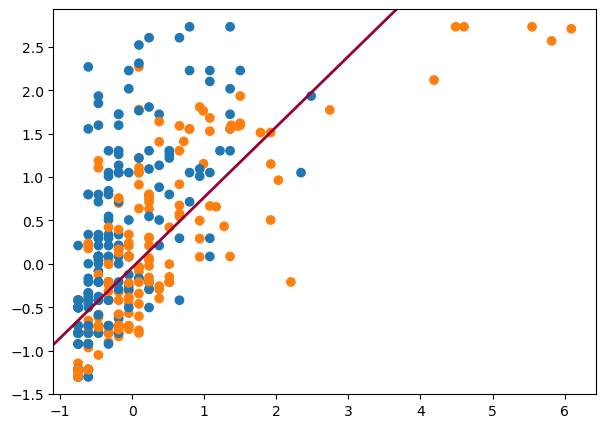

In [97]:
def separator_2d(model, x1):
    w = model.coef_[0]
    b = model.intercept_[0]
    return -x1 * w[0] / w[1] - b / w[1]  # formula della retta iperpiano 


plt.figure(figsize=(7, 5))
#                       V3              V4
plt.scatter(X_sm_val[:, 1], X_sm_val[:, 2], c=pd.Series(y_sm_val).map(color_map))

xlim, ylim = plt.xlim(), plt.ylim()  
sep_x = np.linspace(*xlim, 2)
sep_y = separator_2d(sorted_models[1], sep_x)  # nella posizione 1 di sorted_models c'è la regressione logistica con SMOTE
plt.plot(sep_x, sep_y, c="#990033", linewidth=2)
plt.xlim(xlim)
plt.ylim(ylim);